In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.image as mpimg
import pandas as pd
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import seaborn as sns
import numpy as np
import sys
sys.path.append('..')
from utils.helpers import *
# FILEPATH: /home/bule/projects/MVTec_Visualizer/workspace/mvtec_WIDERESNET50_syntheticAnomalies.ipynb
# PATHs
PROJECT_DATA_PATH='//home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection'
LOG_DIR= '/home/bule/projects/MVTec_Visualizer/tensorboard_logs'

In [2]:
FILENAME = 'MVTEC_WIDERESNET50_3thBlock_embeddings_df'
df = pd.read_pickle(os.path.join(PROJECT_DATA_PATH,FILENAME+'.pkl'))
image_paths=[pts[1:]for pts in df.index]
df = df.set_index(pd.Index(image_paths))

In [8]:
anomaly_categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'cable': ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation'],
    'capsule': ['crack', 'faulty_imprint', 'poke', 'squeeze'],
    'carpet': ['color', 'cut', 'hole', 'metal_contamination', 'thread'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination'],
    'hazelnut': ['crack', 'cut', 'hole', 'print'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke'],
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'pill': ['color', 'contamination', 'crack', 'faulty_imprint', 'pill_type'],
    'screw': ['manipulated_front', 'scratch_head', 'thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil'],
    'toothbrush': ['defective'],
    'transistor': ['bent', 'cut', 'damaged_case', 'misplaced'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'zipper': ['broken_teeth', 'fabric_border', 'split_teeth', 'squeezed_teeth']
}

combined_samples,labels,class_list= create_synset_for_class("hazelnut",df)

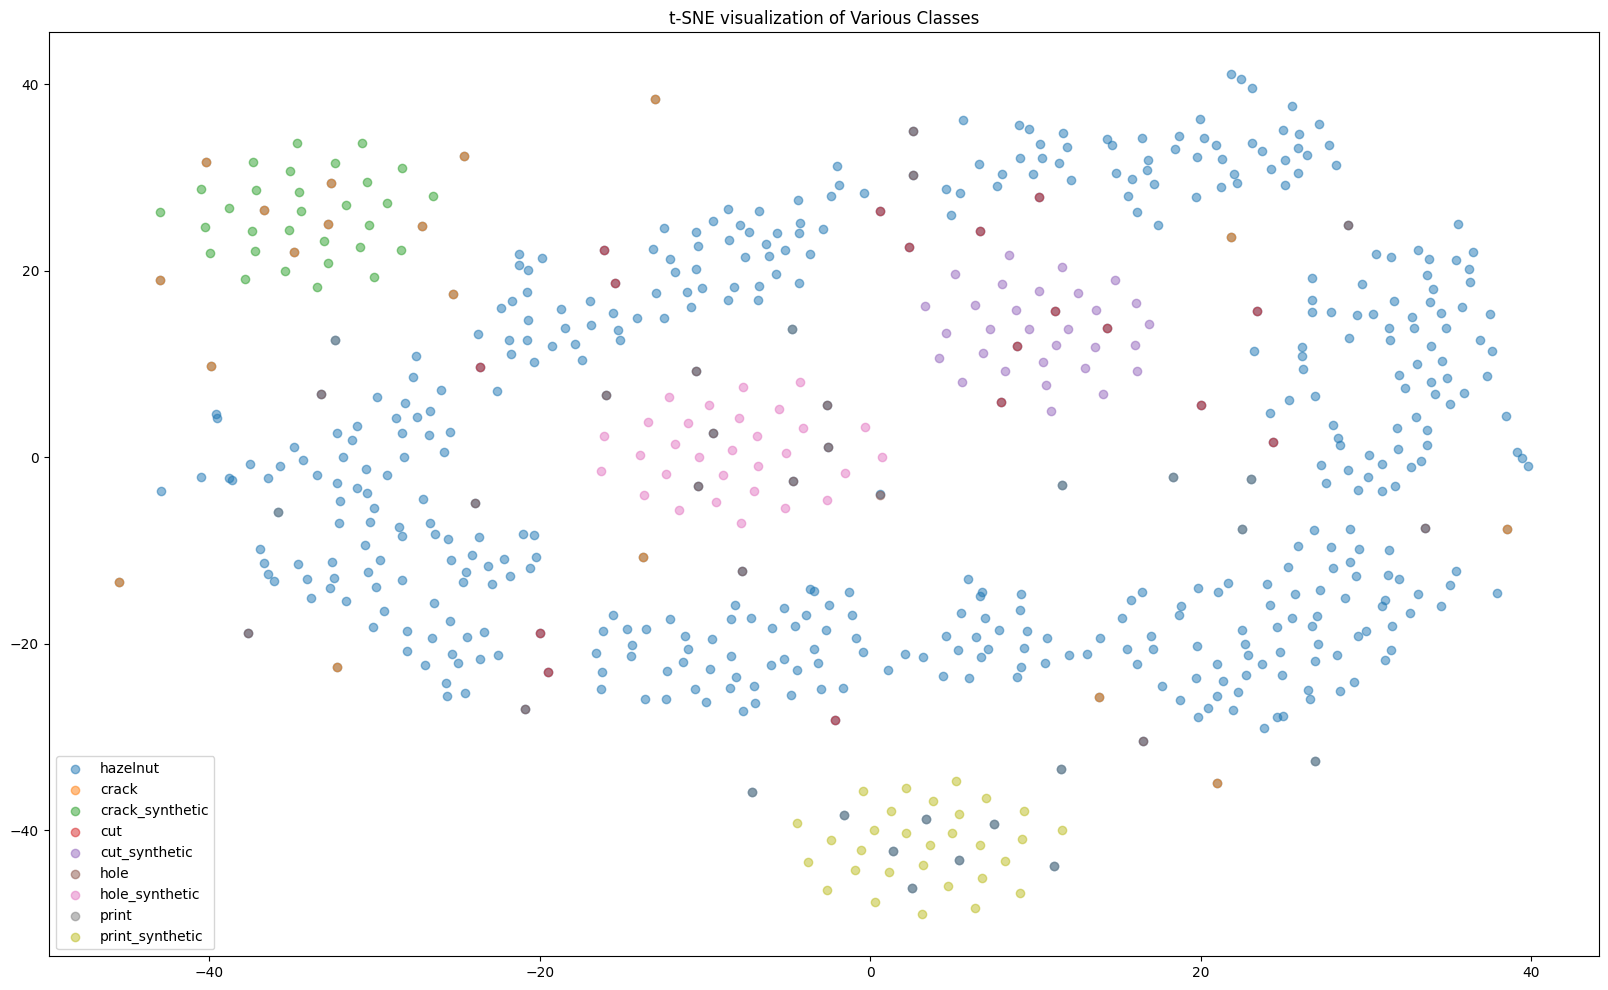

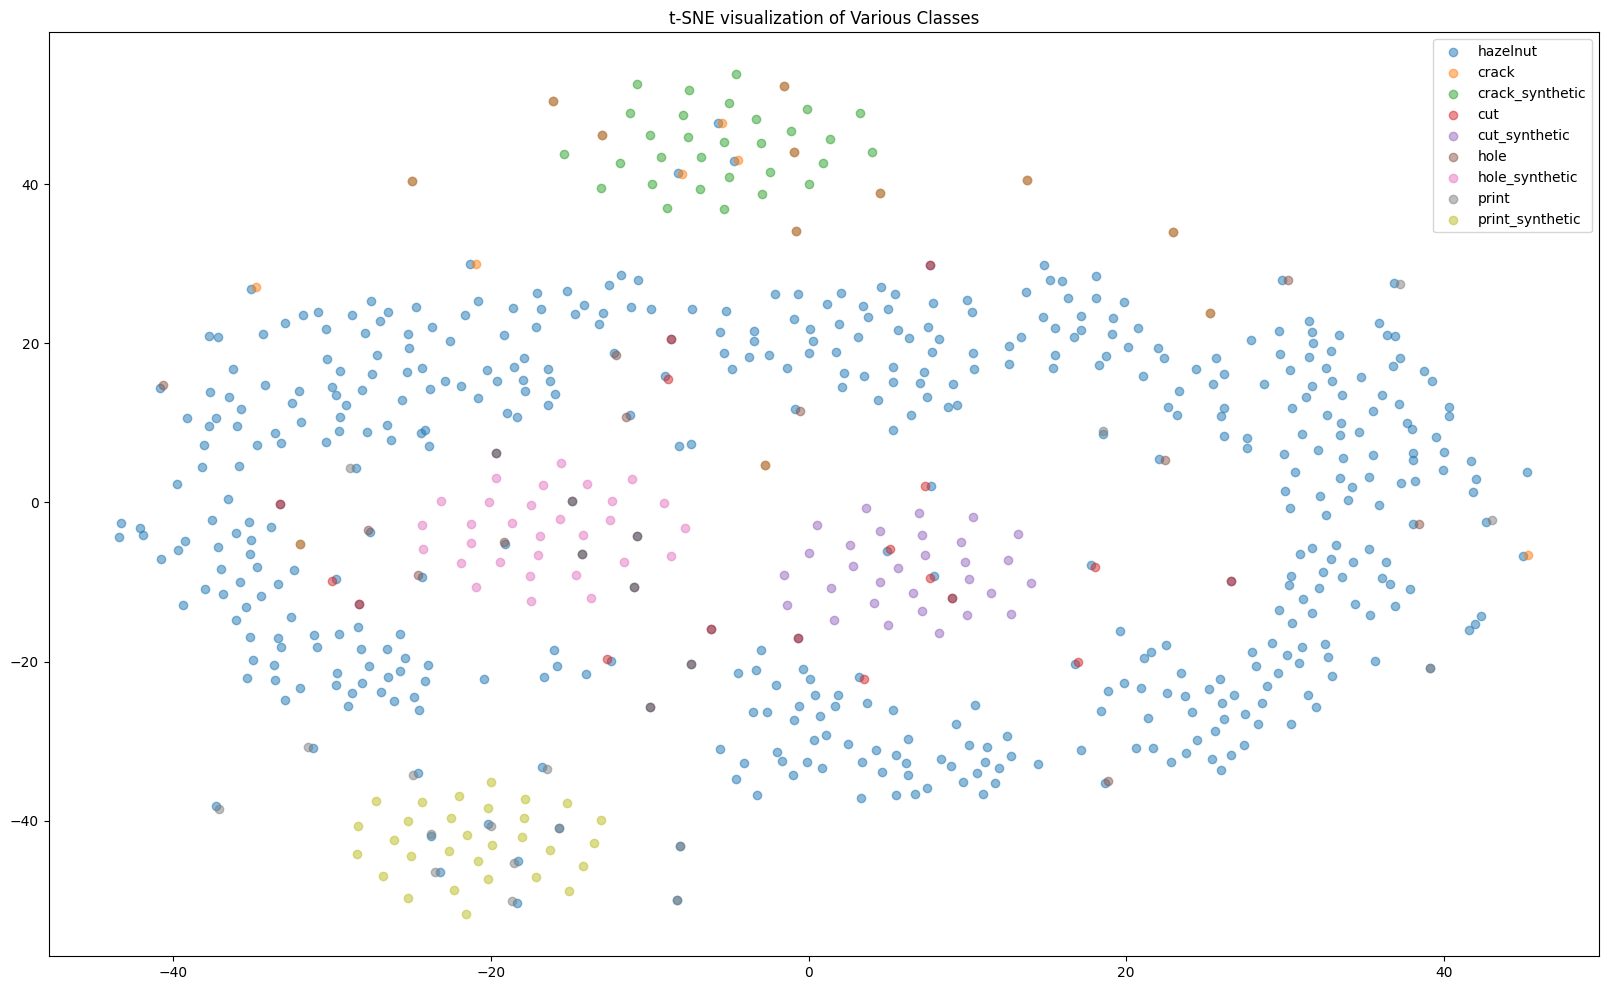

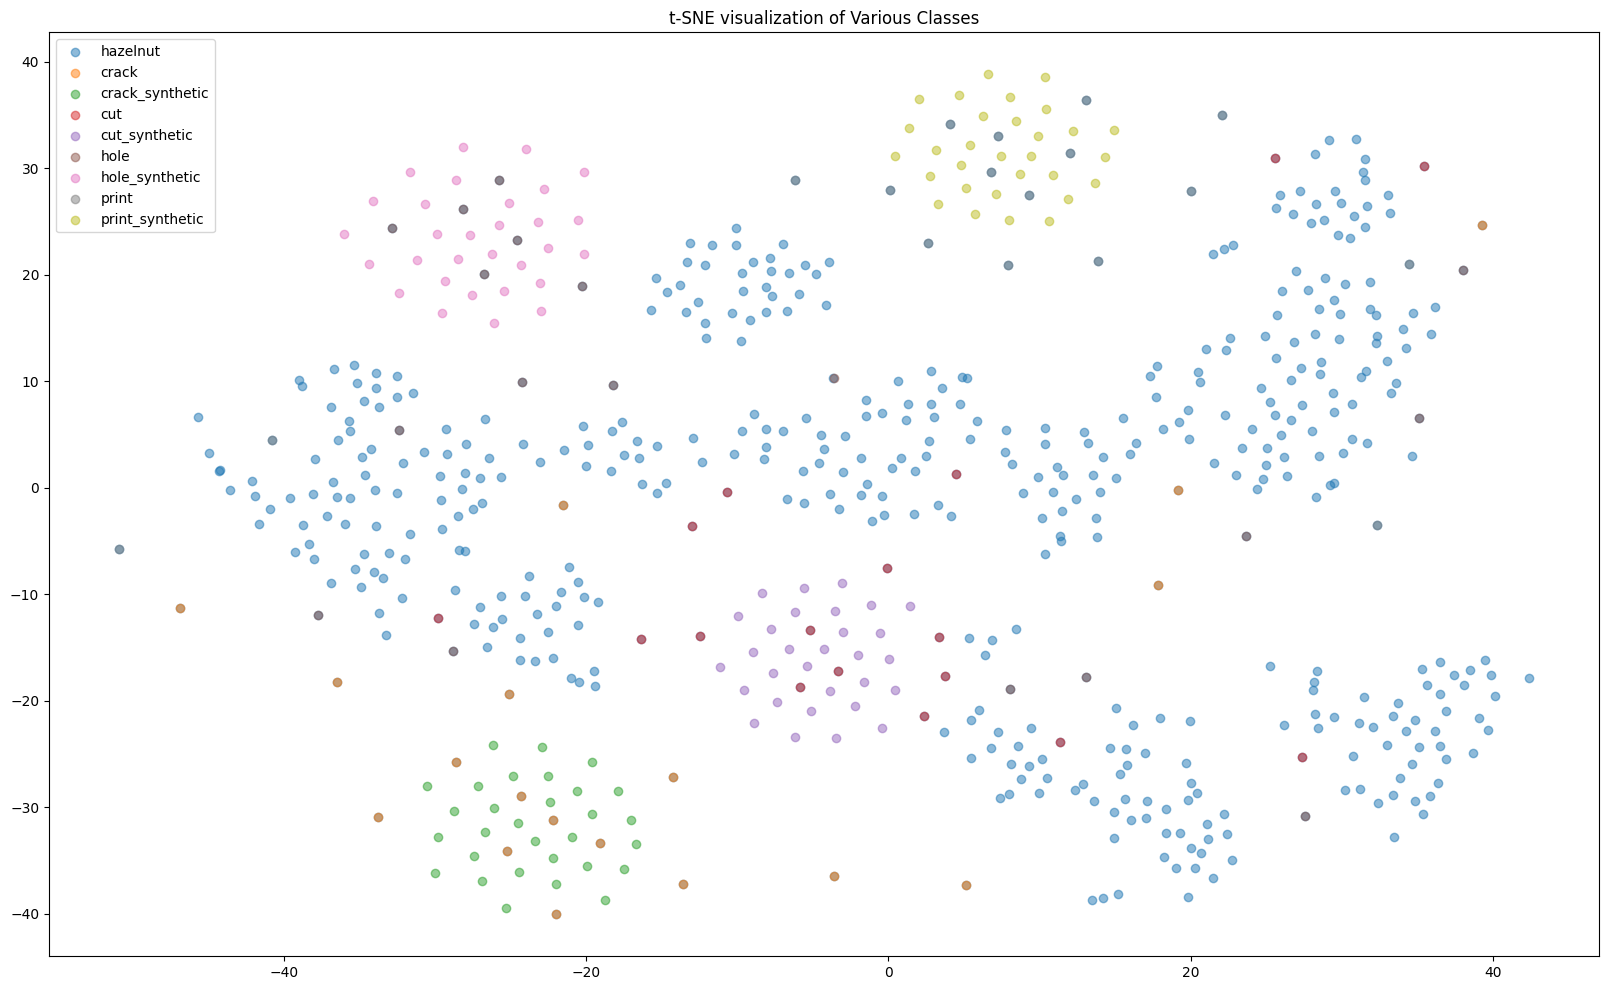

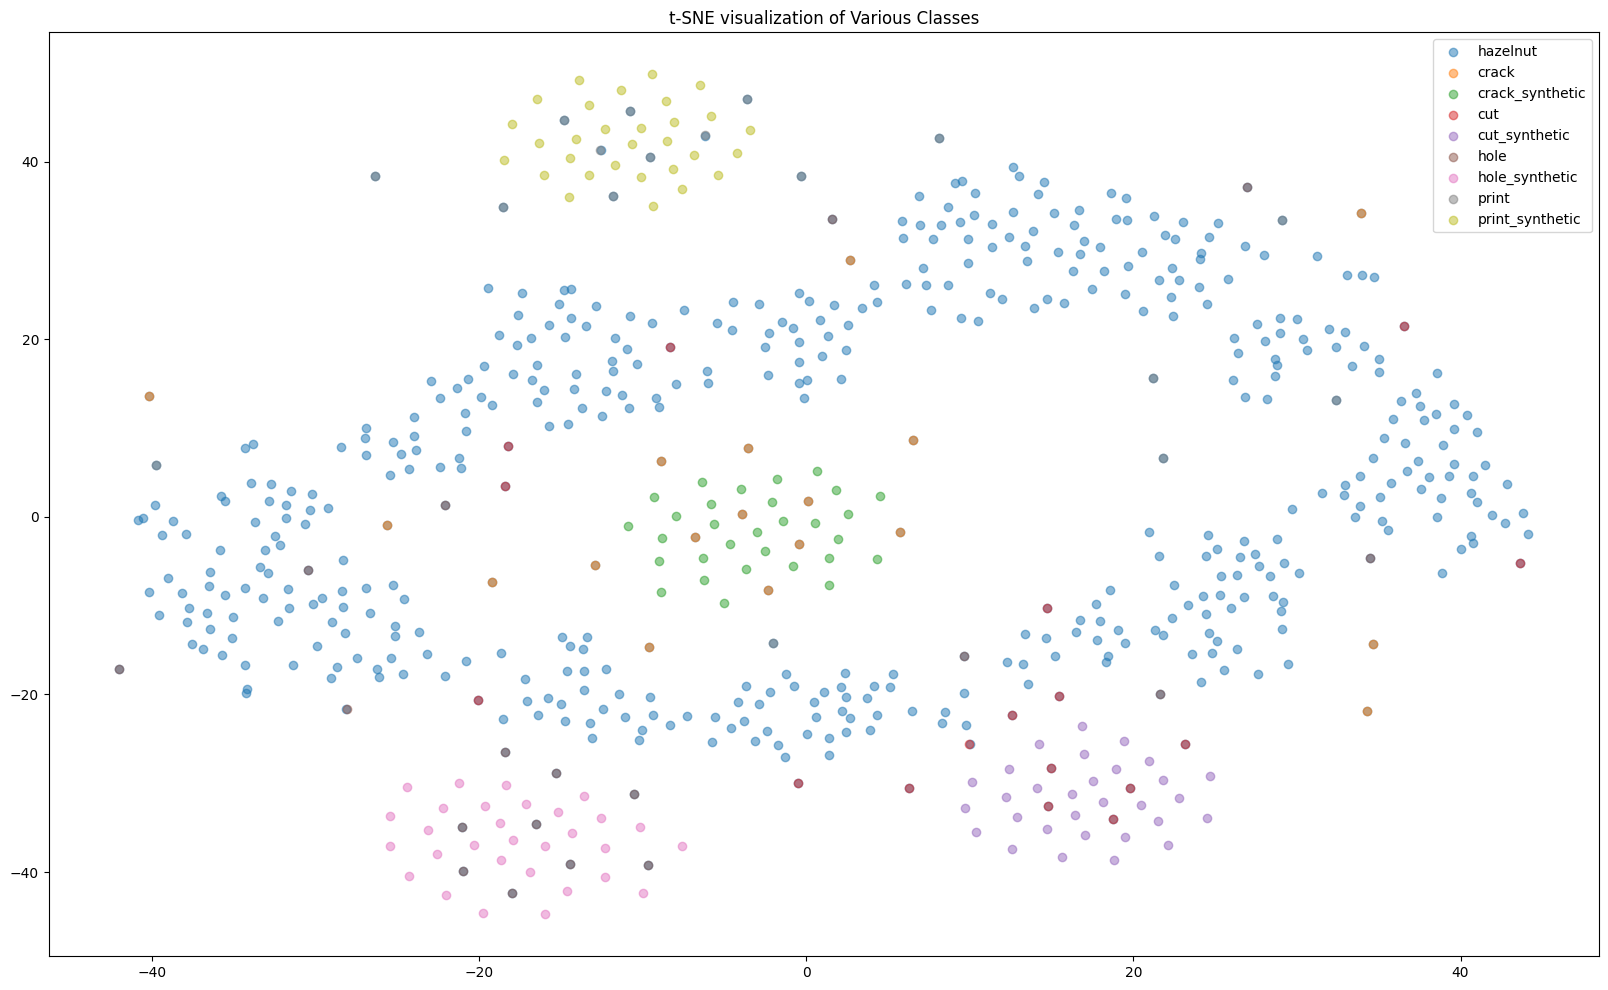

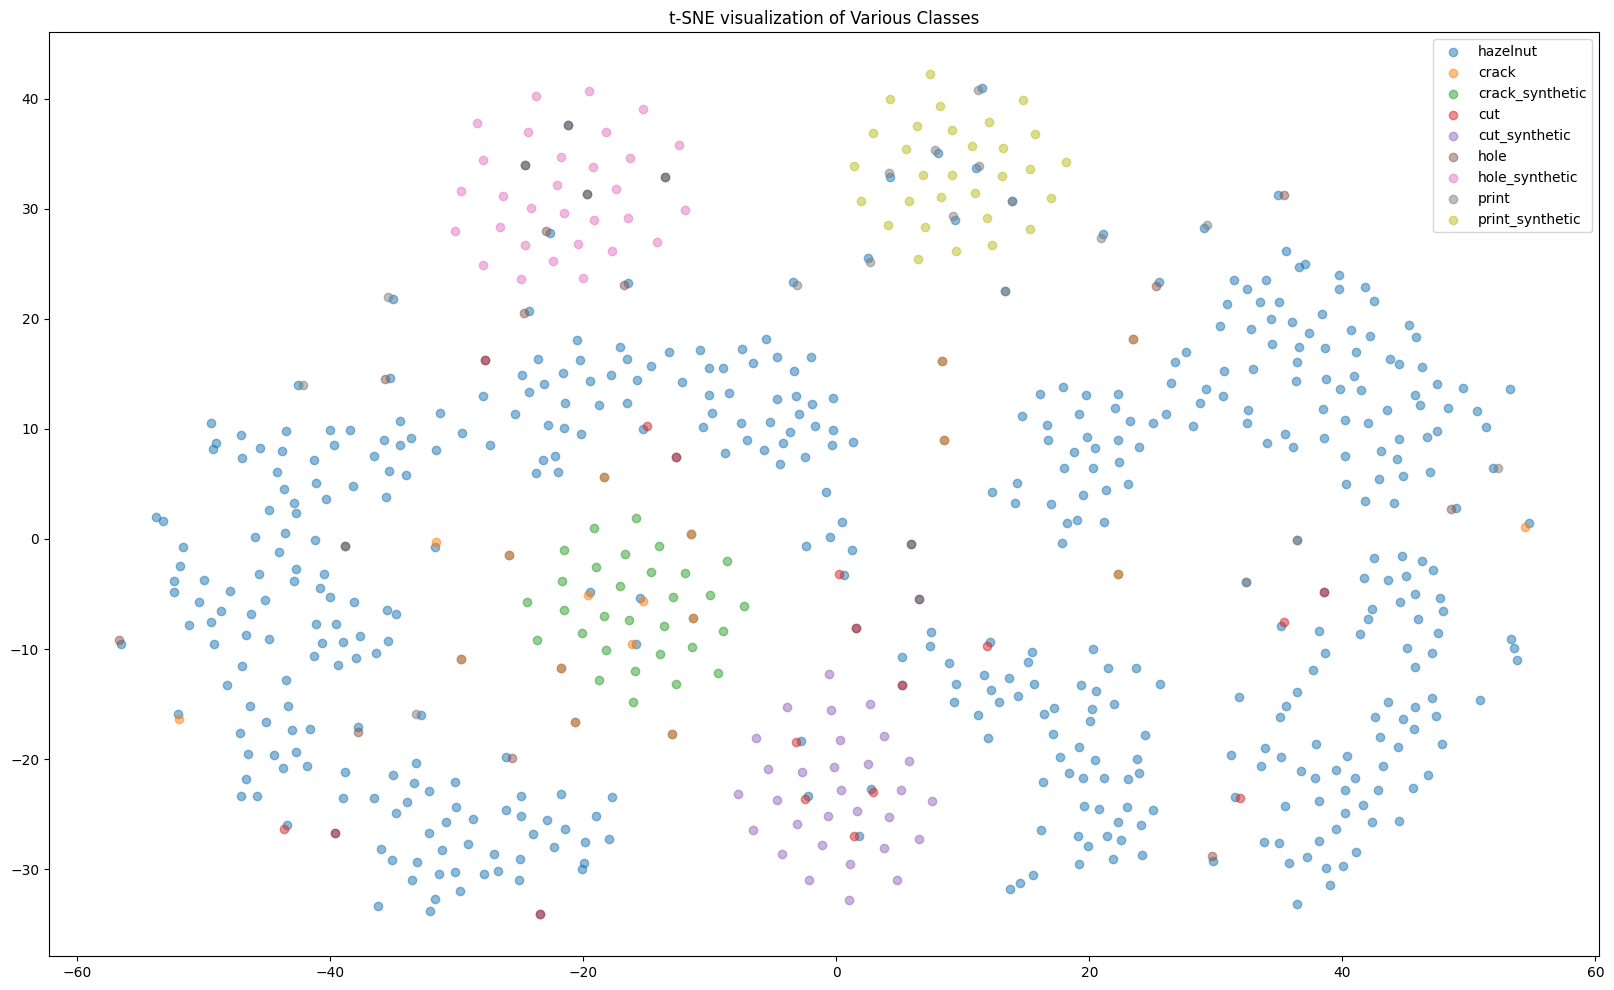

In [10]:
for _ in range(5):

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)#, random_state=0
    reduced_data = tsne.fit_transform(combined_samples)

    # Plotting
    plt.figure(figsize=(20, 12))
    # Iterate over each unique label to plot them separately
    for i in range(len(class_list)):
        plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5)

    plt.title('t-SNE visualization of Various Classes')
    plt.legend()
    plt.show()

